# Modèles Transformer — Comparaison PatchTST, TimeXer, iTransformer, VanillaTransformer

## Objectif
Comparer 4 architectures Transformer modernes pour la prédiction autorégressiive de `Total_reservations`.

## Modèles implémentés

| Modèle | Papier | Idée clé |
|--------|--------|----------|
| **VanillaTransformer** | Vaswani 2017 | Token = pas de temps multivarié |
| **PatchTST** | Nie et al. ICLR 2023 | Token = *patch* (sous-séquence) de la série |
| **TimeXer** | Chen et al. NeurIPS 2024 | PatchTST + Cross-Attention sur les variables exogènes |
| **iTransformer** | Liu et al. ICLR 2024 | Token = *variable* entière (Transformer inversé) |

## Stratégie endogène / exogène
- **Série endogène** : `Total_reservations` — la variable à prédire
- **Features exogènes** : toutes les autres colonnes (météo, jours fériés, jours de semaine…)
  — supposées connues à l'avance (calendaire + prévision météo)

## Paramètres comparables inter-modèles
| Paramètre | Valeur | Rôle |
|-----------|--------|------|
| `WINDOW` | 5 | Jours de contexte (1 semaine ouvrée) |
| `N_TEST` | 5 | Jours à prédire (dernière semaine) |
| `TARGET_COL` | `Total_reservations` | Variable cible |
| `D_MODEL` | 64 | Dimension interne des Transformers |
| `N_HEADS` | 4 | Têtes d'attention |
| `N_LAYERS` | 2 | Couches d'encodeur |

## 1 — Configuration globale

**Modifiez uniquement ce bloc** pour changer les hyperparamètres.

In [1]:
# ─────────────────────────────────────────────────────────────────
# PARAMÈTRES GLOBAUX — modifier ici pour ajuster l'expérience
# ─────────────────────────────────────────────────────────────────
DATA_PATH  = '../data/df_venues_final.csv'
TARGET_COL = 'GLOBAL'               # série endogène

WINDOW      = 5      # jours de contexte
N_TEST      = 5      # jours de test
PATCH_SIZE  = 1      # taille d'un patch (WINDOW doit être divisible par PATCH_SIZE)

# Entraînement
EPOCHS      = 200
LR          = 3e-4
BATCH_SIZE  = 16
PATIENCE    = 40     # early stopping

# Architecture Transformer
D_MODEL     = 64
N_HEADS     = 4
N_LAYERS    = 2
DROPOUT     = 0.1

# Couleurs par modèle (cohérentes dans tous les graphiques)
MODEL_COLORS = {
    'VanillaTransformer': '#C44E52',
    'PatchTST'          : '#4C72B0',
    'TimeXer'           : '#DD8452',
    'iTransformer'      : '#55A868',
}

DAY_LABELS = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi']
IMG_PATH   = '../img/transformers_results.png'

## 2 — Imports

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

warnings.filterwarnings('ignore')
torch.manual_seed(42)
np.random.seed(42)

DEVICE = torch.device('mps' if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available()
                       else 'cuda' if torch.cuda.is_available()
                       else 'cpu')
print(f'PyTorch : {torch.__version__} | Device : {DEVICE}')

PyTorch : 2.10.0 | Device : mps


## 3 — Chargement, préparation et normalisation

Les données sont séparées en :
- **Série endogène** : `Total_reservations` (la cible)
- **Features exogènes** : toutes les autres colonnes

On utilise `StandardScaler` (µ=0, σ=1) ajusté **uniquement sur le train** pour éviter
la fuite d'information du test vers le train.

In [3]:
df = pd.read_csv(DATA_PATH, sep=';')

day_order = {
    'jour_lundi': 0, 'jour_mardi': 1, 'jour_mercredi': 2,
    'jour_jeudi': 3, 'jour_vendredi': 4,
}
for col in day_order:
    df[col] = df[col].map({'True': 1, 'False': 0}).fillna(df[col]).astype(int)

df['day_num'] = df[list(day_order.keys())].idxmax(axis=1).map(day_order)
df = df.sort_values(['Annee', 'Semaine', 'day_num']).reset_index(drop=True)

# Colonnes exogènes = tout sauf TARGET_COL et day_num
EXO_COLS = [c for c in df.columns if c not in [TARGET_COL, 'day_num']]

n          = len(df)
test_start = n - N_TEST

_last = df.iloc[-N_TEST:]
TEST_LABEL = f"S{int(_last.iloc[0]['Semaine'])}/{int(_last.iloc[0]['Annee'])}"

# Normalisation : ajustée sur le train uniquement
scaler_endo = StandardScaler()
scaler_exo  = StandardScaler()

train_endo = scaler_endo.fit_transform(df[[TARGET_COL]].values[:test_start]).flatten()
train_exo  = scaler_exo.fit_transform(df[EXO_COLS].values.astype(float)[:test_start])

test_endo  = scaler_endo.transform(df[[TARGET_COL]].values[test_start:]).flatten()
test_exo   = scaler_exo.transform(df[EXO_COLS].values.astype(float)[test_start:])

all_endo = np.concatenate([train_endo, test_endo])
all_exo  = np.concatenate([train_exo,  test_exo], axis=0)

N_EXO = all_exo.shape[1]

print(f'Shape : {df.shape}  |  Train : {test_start} jours  |  Test : {N_TEST} jours')
print(f'Features exogènes : {N_EXO} → {EXO_COLS[:5]}...')
print(f'Test : {TEST_LABEL}')
print(f'\n--- Dernière semaine de test ---')
print(df[['Annee', 'Semaine', 'day_num', TARGET_COL]].tail(N_TEST).to_string())

Shape : (250, 18)  |  Train : 245 jours  |  Test : 5 jours
Features exogènes : 16 → ['jour_ferie.', 'pont.conge.', 'holiday', 'Semaine', 'Annee']...
Test : S39/2023

--- Dernière semaine de test ---
     Annee  Semaine  day_num  GLOBAL
245   2023       39        0     624
246   2023       39        1     713
247   2023       39        2     623
248   2023       39        3     659
249   2023       39        4     408


## 4 — Dataset et DataLoader

La classe `TSDataset` crée des fenêtres glissantes avec séparation endogène/exogène :
- `x_endo` : série `Total_reservations` des `WINDOW` jours précédents → `(WINDOW,)`
- `x_exo`  : features exogènes sur la même fenêtre → `(WINDOW, N_EXO)`
- `y`      : valeur cible (scalaire normalisé)

In [4]:
class TSDataset(Dataset):
    def __init__(self, endo, exo, win, limit=None):
        self.endo    = torch.tensor(endo, dtype=torch.float32)
        self.exo     = torch.tensor(exo,  dtype=torch.float32)
        self.win     = win
        max_i = limit if limit is not None else len(endo)
        self.indices = list(range(win, max_i))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        return (self.endo[i - self.win : i],    # (W,)
                self.exo [i - self.win : i],    # (W, N_EXO)
                self.endo[i])                   # scalaire


train_ds = TSDataset(all_endo, all_exo, win=WINDOW, limit=test_start)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

print(f'Échantillons train : {len(train_ds)}')
print(f'x_endo : ({BATCH_SIZE}, {WINDOW})  |  x_exo : ({BATCH_SIZE}, {WINDOW}, {N_EXO})')

Échantillons train : 240
x_endo : (16, 5)  |  x_exo : (16, 5, 16)


## 5 — Briques communes

### PositionalEncoding
Encodage positionnel sinusoïdal fixe (Vaswani 2017) pour informer les tokens de leur position.

### PatchEmbedding
Découpe la série en patches de longueur `PATCH_SIZE` et projette chaque patch dans `D_MODEL` dimensions.
Avec `PATCH_SIZE=1` : chaque jour = 1 token (équivalent à une projection par pas de temps).

### ExoEmbedding
Projette les features exogènes `(W, N_EXO)` → `(W, D_MODEL)`.

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512, dropout=0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe  = torch.zeros(max_len, d_model)
        pos = torch.arange(max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return self.dropout(x + self.pe[:, :x.size(1)])


class PatchEmbedding(nn.Module):
    """Découpe (B, W) en (B, n_patches, d_model) — patch_size=1 → 1 token/jour."""
    def __init__(self, window, patch_size, d_model):
        super().__init__()
        assert window % patch_size == 0, 'window doit être divisible par patch_size'
        self.patch_size = patch_size
        self.n_patches  = window // patch_size
        self.proj       = nn.Linear(patch_size, d_model)

    def forward(self, x):
        B, W = x.shape
        x = x.view(B, self.n_patches, self.patch_size)
        return self.proj(x)


class ExoEmbedding(nn.Module):
    """Projette (B, W, n_exo) → (B, W, d_model)."""
    def __init__(self, n_exo, d_model):
        super().__init__()
        self.proj = nn.Linear(n_exo, d_model)

    def forward(self, x):
        return self.proj(x)


print('Briques communes définies ✓')

Briques communes définies ✓


## 6 — Architectures des 4 modèles

### VanillaTransformer
Token = pas de temps multivarié (endogène + exogènes concaténés). Self-Attention temporelle classique.

### PatchTST *(Nie et al. ICLR 2023)*
Token = patch de la série endogène. N'utilise **pas** les exogènes (univarié). La patchification
réduit la séquence et capture la dynamique locale de chaque patch.

### TimeXer *(Chen et al. NeurIPS 2024)*
PatchTST + **Cross-Attention** : les tokens endogènes (Q) interrogent les tokens exogènes (K, V).
$$\text{CrossAttn}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

### iTransformer *(Liu et al. ICLR 2024)*
Token = **variable entière** (toute la série temporelle d'une variable). Self-Attention
inter-variables : le modèle apprend quelles variables sont corrélées.

In [6]:
# ── VanillaTransformer ────────────────────────────────────────────────────
class VanillaTransformer(nn.Module):
    def __init__(self, window, n_exo, d_model, n_heads, n_layers, dropout):
        super().__init__()
        self.input_proj = nn.Linear(1 + n_exo, d_model)
        self.pos_enc    = PositionalEncoding(d_model, dropout=dropout)
        enc = nn.TransformerEncoderLayer(d_model, n_heads, d_model*4, dropout,
                                          batch_first=True, norm_first=True)
        self.encoder = nn.TransformerEncoder(enc, n_layers)
        self.head = nn.Sequential(nn.Linear(d_model, d_model//2), nn.GELU(),
                                   nn.Dropout(dropout), nn.Linear(d_model//2, 1))

    def forward(self, x_endo, x_exo):
        x   = torch.cat([x_endo.unsqueeze(-1), x_exo], dim=-1)  # (B, W, 1+n_exo)
        tok = self.pos_enc(self.input_proj(x))
        return self.head(self.encoder(tok)[:, -1, :]).squeeze(-1)


# ── PatchTST ──────────────────────────────────────────────────────────────
class PatchTST(nn.Module):
    def __init__(self, window, patch_size, d_model, n_heads, n_layers, dropout):
        super().__init__()
        self.patch_emb = PatchEmbedding(window, patch_size, d_model)
        self.pos_enc   = PositionalEncoding(d_model, dropout=dropout)
        enc = nn.TransformerEncoderLayer(d_model, n_heads, d_model*4, dropout,
                                          batch_first=True, norm_first=True)
        self.encoder = nn.TransformerEncoder(enc, n_layers)
        n_patches = window // patch_size
        self.head = nn.Sequential(nn.Flatten(), nn.Linear(n_patches*d_model, d_model),
                                   nn.GELU(), nn.Dropout(dropout), nn.Linear(d_model, 1))

    def forward(self, x_endo, x_exo=None):
        tok = self.pos_enc(self.patch_emb(x_endo))
        return self.head(self.encoder(tok)).squeeze(-1)


# ── TimeXer ───────────────────────────────────────────────────────────────
class TimeXerLayer(nn.Module):
    def __init__(self, d_model, n_heads, dropout):
        super().__init__()
        self.self_attn  = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.ffn  = nn.Sequential(nn.Linear(d_model, d_model*4), nn.GELU(),
                                   nn.Dropout(dropout), nn.Linear(d_model*4, d_model))
        self.n1, self.n2, self.n3 = nn.LayerNorm(d_model), nn.LayerNorm(d_model), nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, endo_tok, exo_tok):
        h = self.n1(endo_tok)
        h, _ = self.self_attn(h, h, h)
        endo_tok = endo_tok + self.drop(h)
        h = self.n2(endo_tok)
        h, _ = self.cross_attn(h, exo_tok, exo_tok)
        endo_tok = endo_tok + self.drop(h)
        h = self.n3(endo_tok)
        return endo_tok + self.drop(self.ffn(h))


class TimeXer(nn.Module):
    def __init__(self, window, n_exo, patch_size, d_model, n_heads, n_layers, dropout):
        super().__init__()
        self.endo_emb = PatchEmbedding(window, patch_size, d_model)
        self.exo_emb  = ExoEmbedding(n_exo, d_model)
        self.pos_endo = PositionalEncoding(d_model, dropout=dropout)
        self.pos_exo  = PositionalEncoding(d_model, dropout=dropout)
        self.layers   = nn.ModuleList([TimeXerLayer(d_model, n_heads, dropout) for _ in range(n_layers)])
        self.norm = nn.LayerNorm(d_model)
        n_patches = window // patch_size
        self.head = nn.Sequential(nn.Flatten(), nn.Linear(n_patches*d_model, d_model),
                                   nn.GELU(), nn.Dropout(dropout), nn.Linear(d_model, 1))

    def forward(self, x_endo, x_exo):
        endo_tok = self.pos_endo(self.endo_emb(x_endo))
        exo_tok  = self.pos_exo(self.exo_emb(x_exo))
        for layer in self.layers:
            endo_tok = layer(endo_tok, exo_tok)
        return self.head(self.norm(endo_tok)).squeeze(-1)


# ── iTransformer ──────────────────────────────────────────────────────────
class iTransformer(nn.Module):
    def __init__(self, window, n_exo, d_model, n_heads, n_layers, dropout):
        super().__init__()
        n_vars = 1 + n_exo
        self.var_emb = nn.Linear(window, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=n_vars+1, dropout=dropout)
        enc = nn.TransformerEncoderLayer(d_model, n_heads, d_model*4, dropout,
                                          batch_first=True, norm_first=True)
        self.encoder = nn.TransformerEncoder(enc, n_layers)
        self.head = nn.Sequential(nn.Linear(d_model, d_model//2), nn.GELU(),
                                   nn.Dropout(dropout), nn.Linear(d_model//2, 1))

    def forward(self, x_endo, x_exo):
        x_mv = torch.cat([x_endo.unsqueeze(-1), x_exo], dim=-1).permute(0, 2, 1)  # (B, n_vars, W)
        tok  = self.pos_enc(self.var_emb(x_mv))
        tok  = self.encoder(tok)
        return self.head(tok[:, 0, :]).squeeze(-1)  # token endogène (index 0)


# ── Instanciation et comptage de paramètres ───────────────────────────────
MODELS_DEF = {
    'VanillaTransformer': VanillaTransformer(WINDOW, N_EXO, D_MODEL, N_HEADS, N_LAYERS, DROPOUT),
    'PatchTST'          : PatchTST(WINDOW, PATCH_SIZE, D_MODEL, N_HEADS, N_LAYERS, DROPOUT),
    'TimeXer'           : TimeXer(WINDOW, N_EXO, PATCH_SIZE, D_MODEL, N_HEADS, N_LAYERS, DROPOUT),
    'iTransformer'      : iTransformer(WINDOW, N_EXO, D_MODEL, N_HEADS, N_LAYERS, DROPOUT),
}

print(f'{"Modèle":<22} | {"Paramètres":>12}')
print('-' * 36)
for name, m in MODELS_DEF.items():
    print(f'{name:<22} | {sum(p.numel() for p in m.parameters()):>12,}')

Modèle                 |   Paramètres
------------------------------------
VanillaTransformer     |      103,233
PatchTST               |      120,705
TimeXer                |      155,457
iTransformer           |      102,465


## 7 — Boucle d'entraînement commune

Même pipeline pour tous les modèles :
- **AdamW** + weight decay
- **CosineAnnealingLR** — décroissance progressive vers LR_min
- **Early stopping** sur la loss train
- **Gradient clipping** (norme max = 1.0)

In [7]:
def train_model(model, train_dl, epochs=EPOCHS, lr=LR, patience=PATIENCE, verbose=True):
    model = model.to(DEVICE)
    opt   = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs, eta_min=lr/100)
    crit  = nn.MSELoss()

    best_loss, best_state, no_improve = float('inf'), None, 0
    history = []

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0
        for x_endo, x_exo, y in train_dl:
            x_endo, x_exo, y = x_endo.to(DEVICE), x_exo.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            loss = crit(model(x_endo, x_exo), y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            epoch_loss += loss.item()
        sched.step()
        avg_loss = epoch_loss / len(train_dl)
        history.append(avg_loss)

        if avg_loss < best_loss - 1e-6:
            best_loss  = avg_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                if verbose: print(f'  Early stopping à l\'epoch {epoch}')
                break

        if verbose and epoch % 50 == 0:
            print(f'  Epoch {epoch:4d}/{epochs}  |  Loss : {avg_loss:.6f}')

    if best_state:
        model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})
    return model, history


@torch.no_grad()
def autoregressive_predict(model, all_endo, all_exo, test_start, window, pred_len):
    """Prédiction autorégressiive sur pred_len jours."""
    model.eval()
    endo_win = list(all_endo[test_start - window : test_start])
    preds_norm = []

    for step in range(pred_len):
        x_endo = torch.tensor(endo_win, dtype=torch.float32).unsqueeze(0).to(DEVICE)
        exo_start = test_start + step - window
        x_exo  = torch.tensor(
            all_exo[exo_start : test_start + step], dtype=torch.float32
        ).unsqueeze(0).to(DEVICE)

        pred_n = model(x_endo, x_exo).item()
        preds_norm.append(pred_n)
        endo_win.pop(0)
        endo_win.append(pred_n)

    preds = scaler_endo.inverse_transform(np.array(preds_norm).reshape(-1, 1)).flatten()
    return preds


print('Fonctions d\'entraînement et d\'inférence définies ✓')

Fonctions d'entraînement et d'inférence définies ✓


## 8 — Entraînement et évaluation des 4 modèles

Chaque modèle est entraîné avec les **mêmes hyperparamètres** pour une comparaison équitable.

In [8]:
real_real = df[TARGET_COL].values[-N_TEST:]

results   = []
histories = {}

for name, model in MODELS_DEF.items():
    print(f'\n{"="*50}')
    print(f' Entraînement : {name}')
    print(f'{"="*50}')

    trained, history = train_model(model, train_dl, verbose=True)
    histories[name]  = history

    preds = autoregressive_predict(trained, all_endo, all_exo,
                                    test_start=test_start, window=WINDOW, pred_len=N_TEST)

    mae  = mean_absolute_error(real_real, preds)
    mape = mean_absolute_percentage_error(real_real, preds) * 100
    rmse = np.sqrt(np.mean((real_real - preds) ** 2))
    r2   = r2_score(real_real, preds)

    results.append(dict(model=name, preds=preds, MAE=mae, MAPE=mape, RMSE=rmse, R2=r2))
    print(f'  → MAE={mae:.1f}  MAPE={mape:.1f}%  RMSE={rmse:.1f}  R²={r2:.4f}')

# ── Résumé comparatif ─────────────────────────────────────────────────────
print(f'\n{"="*60}')
print(f' RÉSUMÉ COMPARATIF — {TEST_LABEL}')
print(f'{"="*60}')
print(f'  {"Modèle":<22} | {"MAE":>6}  {"MAPE":>7}  {"RMSE":>6}  {"R²":>7}')
print(f'  {"-"*55}')
for r in sorted(results, key=lambda x: x['MAE']):
    print(f'  {r["model"]:<22} | {r["MAE"]:>6.1f}  {r["MAPE"]:>6.1f}%  {r["RMSE"]:>6.1f}  {r["R2"]:>7.4f}')


 Entraînement : VanillaTransformer
  Epoch   50/200  |  Loss : 0.230142
  Epoch  100/200  |  Loss : 0.140536
  Epoch  150/200  |  Loss : 0.105518
  Epoch  200/200  |  Loss : 0.092584
  → MAE=69.8  MAPE=12.3%  RMSE=71.3  R²=0.5295

 Entraînement : PatchTST
  Epoch   50/200  |  Loss : 0.375259
  Epoch  100/200  |  Loss : 0.218398
  Epoch  150/200  |  Loss : 0.165285
  Epoch  200/200  |  Loss : 0.140384
  → MAE=87.2  MAPE=15.0%  RMSE=89.8  R²=0.2551

 Entraînement : TimeXer
  Epoch   50/200  |  Loss : 0.173108
  Epoch  100/200  |  Loss : 0.088990
  Epoch  150/200  |  Loss : 0.069251
  Epoch  200/200  |  Loss : 0.061900
  → MAE=45.2  MAPE=8.4%  RMSE=53.5  R²=0.7349

 Entraînement : iTransformer
  Epoch   50/200  |  Loss : 0.306801
  Epoch  100/200  |  Loss : 0.177799
  Epoch  150/200  |  Loss : 0.163106
  Epoch  200/200  |  Loss : 0.154942
  → MAE=58.0  MAPE=10.5%  RMSE=61.3  R²=0.6525

 RÉSUMÉ COMPARATIF — S39/2023
  Modèle                 |    MAE     MAPE    RMSE       R²
  -----------

## 9 — Métriques individuelles (format standardisé)

Format identique aux autres notebooks pour faciliter la comparaison.

In [9]:
for r in results:
    print(f'╔{"═" * 52}╗')
    print(f'║  Métriques {r["model"]:<{40}}║')
    print(f'╠{"═" * 52}╣')
    print(f'║  MAE   (Erreur absolue moyenne)  : {r["MAE"]:>7.1f} réserv.   ║')
    print(f'║  MAPE  (Erreur % moyenne)        : {r["MAPE"]:>6.2f}%            ║')
    print(f'║  RMSE  (Racine erreur quadrat.)  : {r["RMSE"]:>7.1f} réserv.   ║')
    print(f'║  R²    (Coefficient det.)        : {r["R2"]:>7.4f}             ║')
    print(f'╚{"═" * 52}╝')
    print()

╔════════════════════════════════════════════════════╗
║  Métriques VanillaTransformer                      ║
╠════════════════════════════════════════════════════╣
║  MAE   (Erreur absolue moyenne)  :    69.8 réserv.   ║
║  MAPE  (Erreur % moyenne)        :  12.32%            ║
║  RMSE  (Racine erreur quadrat.)  :    71.3 réserv.   ║
║  R²    (Coefficient det.)        :  0.5295             ║
╚════════════════════════════════════════════════════╝

╔════════════════════════════════════════════════════╗
║  Métriques PatchTST                                ║
╠════════════════════════════════════════════════════╣
║  MAE   (Erreur absolue moyenne)  :    87.2 réserv.   ║
║  MAPE  (Erreur % moyenne)        :  15.01%            ║
║  RMSE  (Racine erreur quadrat.)  :    89.8 réserv.   ║
║  R²    (Coefficient det.)        :  0.2551             ║
╚════════════════════════════════════════════════════╝

╔════════════════════════════════════════════════════╗
║  Métriques TimeXer                     

## 10 — Visualisations comparatives

Trois graphiques standardisés :
1. **Prédictions vs Réel** — courbes jour par jour
2. **Courbes de convergence** — loss MSE par epoch (échelle log)
3. **Barplot MAE & RMSE** — comparaison directe inter-modèles

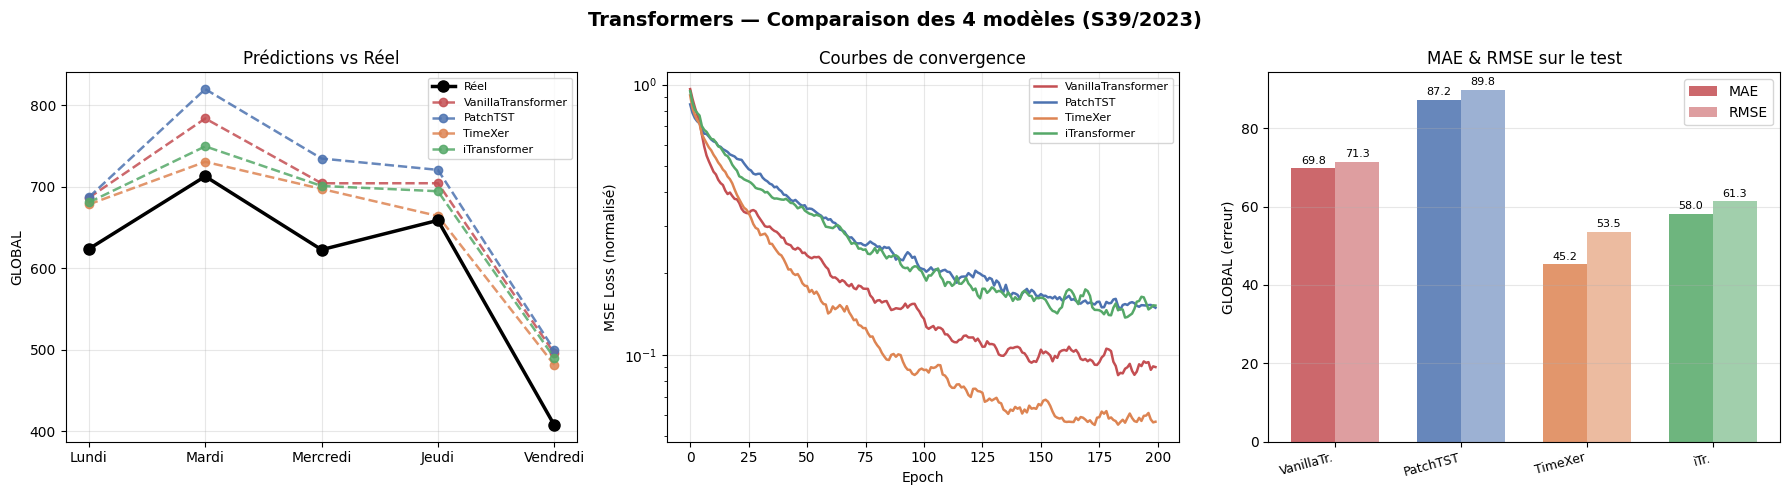

Figure sauvegardée → ../img/transformers_results.png


In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f'Transformers — Comparaison des 4 modèles ({TEST_LABEL})',
             fontsize=14, fontweight='bold')

# ── 1 : Prédictions vs Réel ───────────────────────────────────────────────
ax = axes[0]
ax.plot(range(N_TEST), real_real, 'ko-', lw=2.5, ms=8, label='Réel', zorder=5)
for r in results:
    ax.plot(range(N_TEST), r['preds'], 'o--', lw=1.8, ms=6,
            color=MODEL_COLORS[r['model']], label=r['model'], alpha=0.85)
ax.set_xticks(range(N_TEST))
ax.set_xticklabels(DAY_LABELS)
ax.set_ylabel(TARGET_COL)
ax.set_title('Prédictions vs Réel')
ax.legend(fontsize=8)
ax.grid(alpha=0.3)

# ── 2 : Courbes de convergence ────────────────────────────────────────────
ax = axes[1]
for name, hist in histories.items():
    smooth = pd.Series(hist).rolling(5, min_periods=1).mean()
    ax.plot(smooth, lw=1.8, color=MODEL_COLORS[name], label=name)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss (normalisé)')
ax.set_title('Courbes de convergence')
ax.legend(fontsize=8)
ax.set_yscale('log')
ax.grid(alpha=0.3)

# ── 3 : Barplot MAE & RMSE ────────────────────────────────────────────────
ax = axes[2]
model_names = [r['model'].replace('Transformer', 'Tr.') for r in results]
maes  = [r['MAE']  for r in results]
rmses = [r['RMSE'] for r in results]
x = np.arange(len(model_names))
w = 0.35
b1 = ax.bar(x - w/2, maes,  w, label='MAE',  alpha=0.85,
            color=[MODEL_COLORS[r['model']] for r in results])
b2 = ax.bar(x + w/2, rmses, w, label='RMSE', alpha=0.55,
            color=[MODEL_COLORS[r['model']] for r in results])
ax.bar_label(b1, fmt='%.1f', fontsize=8, padding=2)
ax.bar_label(b2, fmt='%.1f', fontsize=8, padding=2)
ax.set_xticks(x)
ax.set_xticklabels(model_names, fontsize=9, rotation=15, ha='right')
ax.set_ylabel(f'{TARGET_COL} (erreur)')
ax.set_title('MAE & RMSE sur le test')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(IMG_PATH, dpi=150, bbox_inches='tight')
plt.show()
print(f'Figure sauvegardée → {IMG_PATH}')

## 11 — Tableau détaillé jour par jour

In [11]:
print(f'{"Jour":<10} {"Réel":>6}', end='')
for r in results:
    short = r['model'].replace('Transformer', 'Tr.')
    print(f'  {short:>16}', end='')
print()
print('-' * (16 + 6 + len(results) * 18))

for j, day in enumerate(DAY_LABELS):
    print(f'{day:<10} {real_real[j]:>6.0f}', end='')
    for r in results:
        pred = r['preds'][j]
        err  = pred - real_real[j]
        print(f'  {pred:>8.0f} ({err:>+5.0f})', end='')
    print()

print()
print(f'{"Modèle":<22} | {"MAE":>6}  {"MAPE":>7}  {"RMSE":>6}  {"R²":>7}')
print('-' * 52)
for r in sorted(results, key=lambda x: x['MAE']):
    print(f'{r["model"]:<22} | {r["MAE"]:>6.1f}  {r["MAPE"]:>6.1f}%  {r["RMSE"]:>6.1f}  {r["R2"]:>7.4f}')

Jour         Réel        VanillaTr.          PatchTST           TimeXer              iTr.
----------------------------------------------------------------------------------------------
Lundi         624       687 (  +63)       687 (  +63)       679 (  +55)       681 (  +57)
Mardi         713       784 (  +71)       820 ( +107)       731 (  +18)       750 (  +37)
Mercredi      623       704 (  +81)       735 ( +112)       698 (  +75)       701 (  +78)
Jeudi         659       705 (  +46)       721 (  +62)       664 (   +5)       695 (  +36)
Vendredi      408       496 (  +88)       500 (  +92)       482 (  +74)       490 (  +82)

Modèle                 |    MAE     MAPE    RMSE       R²
----------------------------------------------------
TimeXer                |   45.2     8.4%    53.5   0.7349
iTransformer           |   58.0    10.5%    61.3   0.6525
VanillaTransformer     |   69.8    12.3%    71.3   0.5295
PatchTST               |   87.2    15.0%    89.8   0.2551
